In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p = sns.color_palette()

USE_SAMPLE = False
TRAIN_FACE = './sample/train_face.txt' if USE_SAMPLE else './data/train_face.txt'
TRAIN_USER_INTERACT = './sample/train_interaction.txt' if USE_SAMPLE else './data/train_interaction.txt'
TRAIN_TEXT = './sample/train_text.txt' if USE_SAMPLE else './data/train_text.txt'
TEST_FACE = './sample/test_face.txt' if USE_SAMPLE else './data/test_face.txt'
TEST_INTERACT = './sample/test_interaction.txt' if USE_SAMPLE else './data/test_interaction.txt'
TEST_TEXT = './sample/test_text.txt' if USE_SAMPLE else './data/test_text.txt'

In [2]:
face_train = pd.read_csv(TRAIN_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [3]:
user_item_train = pd.read_csv(TRAIN_USER_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click', 'like', 'follow', 'time', 'playing_time', 'duration_time'])

In [4]:
text_train = pd.read_csv(TRAIN_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [5]:
face_test = pd.read_csv(TEST_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [6]:
user_item_test = pd.read_csv(TEST_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'time', 'duration_time'])

In [7]:
text_test = pd.read_csv(TEST_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [8]:
alpha = 2.5171267342473382
beta = 7.087836849232511

In [9]:
ctr = alpha/(alpha+beta)
ctr

0.2620652033055799

# 图片被用户浏览数据分布

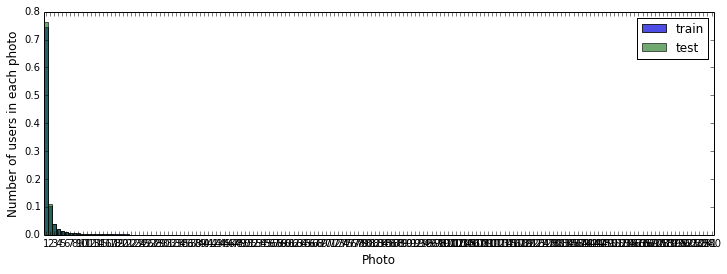

In [9]:
sizes_train = user_item_train.groupby('photo_id')['user_id'].count().value_counts()
sizes_test = user_item_test.groupby('photo_id')['user_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)
sizes_test = sizes_test / np.sum(sizes_test)

plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('Photo', fontsize=12)
plt.ylabel('Number of users in each photo', fontsize=12)

# 图片文本分类 
由于文字数据集是全的，通过对图片文字描述的分类，可以挖掘图片的隐含语义信息，从而对图片进行分类，可以利用这些分类信息，完成图片id的编码


In [28]:
text_data = pd.concat([text_train, text_test])

text_data['photo_id'].nunique()
def words_to_list(words):
        if words == '0':
            return []
        else:
            return words.split(',')
        
text_data['cover_words'] = text_data['cover_words'].apply(words_to_list)
text_data['cover_length'] = text_data['cover_words'].apply(lambda words: len(words))

text_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174532 entries, 0 to 895845
Data columns (total 3 columns):
photo_id        int64
cover_words     object
cover_length    int64
dtypes: int64(2), object(1)
memory usage: 157.9+ MB


In [29]:
text_data.head(20)

,photo_id,cover_words,cover_length
0,1711318,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",196
1,2758458,"[278, 279, 280, 281, 282, 24, 283, 284, 285, 2...",190
2,5314019,"[359, 360, 361, 362, 363, 364, 365, 366, 33, 3...",210
3,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154
4,3161504,"[549, 74, 550, 14, 551, 551, 279, 552, 553, 55...",812
5,1457390,"[0, 735, 164, 736, 76, 737, 738, 739, 0, 738, ...",48
6,55956,"[8, 324, 93, 73, 491, 74, 93, 73, 14, 742, 12,...",190
7,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154
8,2284079,"[8, 324, 93, 73, 491, 74, 93, 73, 14, 742, 12,...",189
9,2228409,"[8, 324, 93, 73, 491, 74, 93, 73, 14, 742, 12,...",189


In [30]:
text_data[(text_data['cover_length']==1) & (text_data['cover_words'] is [0])]

,photo_id,cover_words,cover_length


In [31]:
no_text_photo_ids = list(text_data[text_data['cover_length']==0]['photo_id'].unique())

In [32]:
len(no_text_photo_ids)

2641712

In [33]:
text_photo_ids = list(text_data[text_data['cover_length']>0]['photo_id'].unique())

In [34]:
len(text_photo_ids)

2532820

In [35]:
text_train_photo_ids = list(text_train['photo_id'].unique())
text_train['photo_id'].nunique()
text_test_photo_ids = list(text_test['photo_id'].unique())
text_test['photo_id'].nunique()
interaction_train_photo_ids = list(user_item_train['photo_id'].unique())
user_item_train['photo_id'].nunique()
interaction_test_photo_ids = list(user_item_test['photo_id'].unique())
user_item_test['photo_id'].nunique()

895846

In [36]:
interaction_photo_ids = set(interaction_train_photo_ids + interaction_test_photo_ids)
len(interaction_photo_ids)

5174532

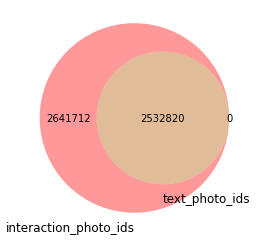

In [37]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(interaction_photo_ids), set(text_photo_ids)], ['interaction_photo_ids', 'text_photo_ids'])
plt.show()

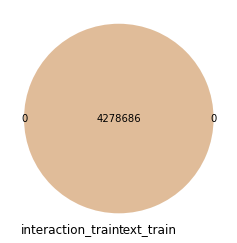

In [38]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(interaction_train_photo_ids), set(text_train_photo_ids)], ['interaction_train', 'text_train'])
plt.show()

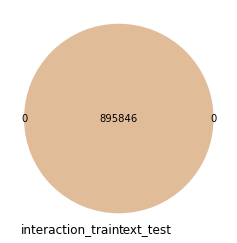

In [39]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(interaction_test_photo_ids), set(text_test_photo_ids)], ['interaction_train', 'text_test'])
plt.show()

## 图片文本分类模型
对于图片的文本数据，我们可以通过不同的模型学习和分类图片，首先由文档有两类表示方法，tfidf 和 word2vec/doc2vec, 然后我们可以采用不同的模型进行聚类（隐含语义分类）或者做分类（二分01点击），可以使用K-means,LDA等进行聚类，也可以用 SVM/LR/GBDT等进行分类，最后尝试LSTM深度学习。

### 模型输入数据表征
#### word2vec

In [11]:
num_features = 128
min_word_count = 40
num_workers = 4
context = 6
downsampling = 1e-3

from gensim.models import word2vec
import os
model = None
model_name = "%dfeatures_%dminwords_%dcontext.model" % (num_features, min_word_count, context)
model_name = model_name + ".sample" if USE_SAMPLE else model_name
if not os.path.exists(model_name):
    print "Training model..."
    model = word2vec.Word2Vec(text_data.cover_words,
                              workers=num_workers,
                              size=num_features,
                              min_count = min_word_count,
                              window = context,
                              sample = downsampling)
    model.init_sims(replace=True)
    model.save(model_name)

model = word2vec.Word2Vec.load(model_name)

Training model...


In [20]:
model.most_similar("0")

/Library/Python/2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('1828', 0.602296769618988),
 ('1526', 0.5761873722076416),
 ('3390', 0.572670042514801),
 ('1516', 0.5605823993682861),
 ('3392', 0.5523289442062378),
 ('3178', 0.5438832640647888),
 ('4895', 0.5339459180831909),
 ('1908', 0.525124192237854),
 ('10702', 0.5236855745315552),
 ('3378', 0.5225512981414795)]

In [13]:
print(model.corpus_count)
print(len(set(model.wv.index2word)))

1337176
8005


#### doc2vec

In [14]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(model, num_features, words):
    featureVec = np.zeros((num_features,),dtype="float64")
    nwords = 0
    # set for fast query
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords*1.0)
    return featureVec


def getAvgFeatureVecs(covers, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(covers),num_features),dtype="float64")
    for cover in covers:
        if counter%100000 == 0:
            print "Cover %d of %d" % (counter, len(covers))
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(cover, model, \
           num_features)
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs

In [15]:
import functools
doc2vec = functools.partial(makeFeatureVec, model, num_features)
text_data['doc_vec'] = text_data['cover_words'].apply(doc2vec)

/Library/Python/2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [22]:
text_data.head()

,photo_id,cover_words,cover_length,doc_vec
0,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154,"[-0.025878702781887516, -0.047330769046244246,..."
1,1035274,"[351, 789, 356, 33, 79, 61, 198, 790, 14, 791,...",154,"[-0.017359135672450066, -0.0212560188619123, -..."
2,5752571,"[1158, 1159, 1160, 1158, 1159, 1160, 1161, 116...",189,"[-0.01641334203929551, -0.009614278170369608, ..."
3,473617,"[1294, 173, 1295, 1296, 14, 1297, 150, 1298, 1...",35,"[0.0024094040409716614, 0.019040408003253535, ..."
4,1040170,"[1474, 1475, 1476, 1477, 1478, 1479, 1480, 148...",18,"[-0.00876109438416149, 0.0368937700654247, 0.0..."


In [23]:
f = 'text_data_docvec'
f = f + '.sample.csv' if USE_SAMPLE else f + '.csv'
text_data['doc_vec'].to_csv(f)

另一种方法是先使用Kmeans对所有的单词做聚类，这可以看成无监督学习出来隐含空间的文本特征属性，每一个类代表一个维度的特征，然后统计一个文本中的单词都属于哪些类的词频作为对应维度的特征值，构成一个DocVector；

这里对文本进行分类可以直接采用得到的Doc2Vec对文本进行聚类，聚类之后，每一个photo就具有类别属性，可以对photo进行编码。

前面的是直接将词向量简单的做平均来构造一个文档的向量DocVector, 当然也可以乘以tf-idf权重。


In [ ]:
USER_FEATURE_TRAIN_FILE = 'user_feature_train'
USER_FEATURE_TRAIN_FILE = USER_FEATURE_TRAIN_FILE + '_sample.csv' if USE_SAMPLE else USER_FEATURE_TRAIN_FILE + '.csv'
user_item_train = pd.read_csv(USER_FEATURE_TRAIN_FILE, sep='\t')

USER_FEATURE_TEST_FILE = 'user_feature_test'
USER_FEATURE_TEST_FILE = USER_FEATURE_TEST_FILE + '_sample.csv' if USE_SAMPLE else USER_FEATURE_TEST_FILE + '.csv'
user_item_test = pd.read_csv(USER_FEATURE_TEST_FILE, sep='\t')

In [41]:
text_data.head()

,photo_id,cover_words,cover_length
0,1711318,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",196
1,2758458,"[278, 279, 280, 281, 282, 24, 283, 284, 285, 2...",190
2,5314019,"[359, 360, 361, 362, 363, 364, 365, 366, 33, 3...",210
3,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154
4,3161504,"[549, 74, 550, 14, 551, 551, 279, 552, 553, 55...",812


In [42]:
text_data.shape

(5174532, 3)

In [43]:
print(text_data.iloc[0]['cover_words'])

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '10', '19', '18', '20', '21', '18', '22', '23', '18', '11', '24', '25', '26', '18', '27', '24', '28', '29', '30', '31', '32', '5', '33', '24', '34', '35', '36', '14', '37', '38', '39', '40', '37', '29', '41', '42', '18', '41', '43', '30', '44', '45', '46', '18', '47', '48', '41', '49', '18', '41', '8', '9', '50', '51', '52', '53', '54', '41', '8', '9', '55', '5', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '14', '66', '67', '68', '69', '70', '71', '41', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '10', '19', '18', '20', '21', '18', '22', '23', '18', '11', '24', '25', '26', '18', '27', '24', '28', '29', '30', '31', '32', '5', '33', '24', '34', '35', '36', '14', '37', '38', '39', '40', '37', '29', '41', '42', '18', '41', '43', '30', '44', '45', '46', '18', '47', '48', '41', '49', '18', '41', '8', '9', '50', '51', '52', 

In [44]:
print(text_data.iloc[1]['cover_words'])

['278', '279', '280', '281', '282', '24', '283', '284', '285', '279', '286', '89', '287', '172', '288', '289', '290', '79', '128', '61', '291', '143', '266', '231', '292', '293', '279', '9', '294', '295', '288', '296', '289', '18', '290', '297', '285', '298', '299', '74', '300', '301', '113', '302', '303', '304', '305', '52', '306', '231', '307', '308', '231', '309', '310', '311', '312', '76', '9', '313', '314', '315', '29', '287', '316', '317', '143', '318', '288', '14', '319', '279', '320', '312', '231', '14', '321', '24', '322', '246', '323', '14', '324', '325', '33', '12', '8', '326', '14', '5', '327', '128', '318', '73', '118', '278', '279', '280', '281', '282', '24', '283', '284', '285', '279', '286', '89', '287', '172', '288', '289', '290', '79', '128', '61', '291', '143', '266', '231', '292', '293', '279', '9', '294', '295', '288', '296', '289', '18', '290', '297', '285', '298', '299', '74', '300', '301', '113', '302', '303', '304', '305', '52', '306', '231', '307', '308', '231

In [45]:
print(text_data.iloc[2]['cover_words'])

['359', '360', '361', '362', '363', '364', '365', '366', '33', '367', '68', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '8', '379', '29', '380', '381', '382', '369', '57', '43', '383', '384', '385', '386', '82', '29', '387', '388', '389', '390', '391', '392', '393', '394', '395', '76', '396', '30', '397', '398', '399', '33', '400', '401', '402', '64', '403', '404', '405', '406', '407', '86', '408', '79', '409', '410', '128', '317', '73', '411', '88', '412', '96', '413', '91', '414', '96', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '369', '431', '432', '433', '76', '434', '79', '418', '435', '428', '436', '437', '73', '438', '439', '231', '280', '440', '280', '441', '442', '443', '444', '24', '445', '446', '447', '369', '448', '449', '450', '451', '12', '452', '450', '453', '454', '455', '456', '457', '74', '458', '408', '459', '224', '460', '461', '462', '463', '464', '390', '465', '96

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.08)

In [86]:
corpus = text_data['cover_words'].apply(lambda words: ' '.join(words))

In [112]:
from collections import Counter
text = list()
for doc in text_data['cover_words']:
    text.extend(doc)

In [114]:
c = Counter(text)

In [130]:
len(c)

233243

In [133]:
486514. / 5174532

0.09402086990668915

In [122]:
sorted(c.iteritems(), key=lambda x :x[1], reverse=True)[:20]

[('14', 486514),
 ('18', 431876),
 ('143', 232551),
 ('73', 164121),
 ('0', 116487),
 ('76', 115414),
 ('29', 109436),
 ('74', 95020),
 ('9', 71572),
 ('149', 71128),
 ('33', 69759),
 ('86', 66111),
 ('12', 62943),
 ('1152', 62312),
 ('24', 61192),
 ('369', 59539),
 ('563', 59433),
 ('45', 58225),
 ('30', 49194),
 ('164', 47094)]

In [129]:
'149' in words

True

In [135]:
tfidf = vectorizer.fit_transform(corpus)

In [136]:
tfidf.shape

(5174532, 233232)

In [137]:
avg_tfidf = np.mean(tfidf, axis=1)

In [138]:
avg_tfidf

matrix([[2.97993242e-05],
        [3.22933164e-05],
        [5.42490012e-05],
        ...,
        [1.53207939e-05],
        [1.68956530e-05],
        [1.96312587e-05]])

In [139]:
text_data['avg_tfidf'] = avg_tfidf

In [140]:
text_data.head()

,photo_id,cover_words,cover_length,avg_tfidf
0,1711318,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",196,0.000030
1,2758458,"[278, 279, 280, 281, 282, 24, 283, 284, 285, 2...",190,0.000032
2,5314019,"[359, 360, 361, 362, 363, 364, 365, 366, 33, 3...",210,0.000054
3,5735948,"[508, 509, 510, 511, 512, 508, 513, 514, 515, ...",154,0.000020
4,3161504,"[549, 74, 550, 14, 551, 551, 279, 552, 553, 55...",812,0.000052


In [141]:
text_data[text_data['avg_tfidf']==0].shape

(2642343, 4)

In [94]:
words = vectorizer.get_feature_names()

In [84]:
len(words)

233233

In [132]:
vectorizer.vocabulary_

{u'228055': 108649,
 u'228054': 108648,
 u'228057': 108650,
 u'228051': 108646,
 u'228050': 108645,
 u'228053': 108647,
 u'287145': 152226,
 u'228059': 108651,
 u'287146': 152227,
 u'89371': 223098,
 u'89372': 223099,
 u'89373': 223100,
 u'89374': 223101,
 u'89376': 223102,
 u'89377': 223103,
 u'89378': 223104,
 u'89379': 223105,
 u'287141': 152223,
 u'123851': 22121,
 u'5988': 194170,
 u'5989': 194179,
 u'287142': 152224,
 u'123850': 22120,
 u'5982': 194112,
 u'5983': 194120,
 u'5980': 194090,
 u'5981': 194101,
 u'5986': 194149,
 u'5987': 194160,
 u'5984': 194130,
 u'5985': 194139,
 u'38844': 172706,
 u'79236': 213278,
 u'218135': 100943,
 u'218134': 100942,
 u'287148': 152228,
 u'218137': 100944,
 u'184242': 73839,
 u'194080': 81735,
 u'123859': 22129,
 u'252561': 127225,
 u'218131': 100939,
 u'218130': 100938,
 u'218133': 100941,
 u'194081': 81736,
 u'97159': 230528,
 u'97158': 230527,
 u'12995': 27609,
 u'97153': 230523,
 u'97152': 230522,
 u'97150': 230521,
 u'97157': 230526,
 u'9

In [ ]:
for i in range(tfidf.shape[0]):
    print('----Document %d----' % (i))
    for j in range(len(words)):
        if tfidf[i,j] > 1e-5:
              print( words[j], tfidf[i,j])

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

#语料
corpus = [
        'This is the first document.',
        'This is the second second document.',
        'And the third one.'
        'Is this the first document?'
        ]

# 将文本中的词语，转换成词频矩阵

vectorizer = CountVectorizer(max_df=0.8)

# 计算词语出现的频率
X = vectorizer.fit_transform(corpus)

# 获取词袋中所有文本关键词
words = vectorizer.get_feature_names()
print(words)

[u'and', u'first', u'one', u'second', u'third']


In [46]:
vectorizer.vocabulary_

{u'and': 0, u'first': 1, u'one': 2, u'second': 3, u'third': 4}

In [41]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 1, 1, 1, 1, 0, 2, 1, 1]])

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

#语料
corpus = [
        'This is the first document.',
        'This is the second second document.',
        'And the third one.'
        'Is this the first document?'
        ]

# 将文本中的词语，转换成词频矩阵

vectorizer = TfidfVectorizer()

# 计算词语出现的频率
X = vectorizer.fit_transform(corpus)

# 获取词袋中所有文本关键词
words = vectorizer.get_feature_names()
print(words)

[u'and', u'document', u'first', u'is', u'one', u'second', u'the', u'third', u'this']


In [43]:
X.toarray()

array([[0.        , 0.42040099, 0.54134281, 0.42040099, 0.        ,
        0.        , 0.42040099, 0.        , 0.42040099],
       [0.        , 0.25427116, 0.        , 0.25427116, 0.        ,
        0.861037  , 0.25427116, 0.        , 0.25427116],
       [0.4075631 , 0.24071333, 0.30996224, 0.24071333, 0.4075631 ,
        0.        , 0.48142667, 0.4075631 , 0.24071333]])

In [144]:
set([1,2,4,5]) in set([1,2,3,4,5])

False

# 图片的行为交互属性
图片本身被用户交互曝光点击等属性，以及视频时长等属性

In [183]:
#!/usr/bin/python
# coding=utf-8

import numpy
import random
import scipy.special as special

class BayesianSmoothing(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def sample(self, alpha, beta, num, imp_upperbound):
        sample = numpy.random.beta(alpha, beta, num)
        print(sample)
        I = []
        C = []
        for clk_rt in sample:
            imp = imp_upperbound
            clk = imp * clk_rt
            I.append(imp)
            C.append(clk)
        return I, C

    def update(self, imps, clks, iter_num, epsilon):
        for i in range(iter_num):
            new_alpha, new_beta = self.__fixed_point_iteration(imps, clks, self.alpha, self.beta)
            if abs(new_alpha-self.alpha)<epsilon and abs(new_beta-self.beta)<epsilon:
                break
            self.alpha = new_alpha
            self.beta = new_beta

    def __fixed_point_iteration(self, imps, clks, alpha, beta):
        numerator_alpha = 0.0
        numerator_beta = 0.0
        denominator = 0.0

        for i in range(len(imps)):
            numerator_alpha += (special.digamma(clks[i]+alpha) - special.digamma(alpha))
            numerator_beta += (special.digamma(imps[i]-clks[i]+beta) - special.digamma(beta))
            denominator += (special.digamma(imps[i]+alpha+beta) - special.digamma(alpha+beta))

        return alpha*(numerator_alpha/denominator), beta*(numerator_beta/denominator)

def main():
    bs = BayesianSmoothing(1, 1)
    I, C = bs.sample(500, 500, 10, 1000)
    print(I, C)
    bs.update(I, C, 1000, 0.0000000001)
    print(bs.alpha, bs.beta)
    ctr = []
    for i in range(len(I)):
        ctr.append((C[i]+bs.alpha)/(I[i]+bs.alpha+bs.beta))
    print(ctr)

if __name__ == '__main__':
    main()

[0.5126139  0.47536132 0.47519824 0.48996173 0.49128503 0.53275642
 0.49663963 0.49234455 0.49628574 0.50455946]
([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [512.6138964778866, 475.36131893976903, 475.19823812359937, 489.96172705681954, 491.2850251717192, 532.7564183245967, 496.6396282679757, 492.3445544156475, 496.2857418791724, 504.5594577374588])
(77.34025414825255, 78.3610578300499)
[0.5104728570535837, 0.4782391153834722, 0.47809800555303467, 0.49087249043092096, 0.4920175078339336, 0.5279016871829106, 0.4966507145636989, 0.4929342925022097, 0.4963445053510456, 0.503503548758311]


In [184]:
items = pd.DataFrame()
common = ['photo_id', 'duration_time', 'time']
items[common] = user_item_train[common]

items['exposure_num'] = user_item_train['photo_id'].groupby(user_item_train['photo_id']).transform('count')
items['clicked_num'] = user_item_train['click'].groupby(user_item_train['photo_id']).transform('sum')
items['liked_num'] = user_item_train['like'].groupby(user_item_train['photo_id']).transform('sum')
items['followed_num'] = user_item_train['follow'].groupby(user_item_train['photo_id']).transform('sum')
items['played_sum'] = user_item_train['playing_time'].groupby(user_item_train['photo_id']).transform('sum')
items['duration_sum'] = user_item_train['duration_time'].groupby(user_item_train['photo_id']).transform('sum')
items['clicked_ratio'] = user_item_train['click'].groupby(user_item_train['photo_id']).transform('mean')
items['liked_ratio'] = user_item_train['like'].groupby(user_item_train['photo_id']).transform('mean')
items['followed_ratio'] = user_item_train['follow'].groupby(user_item_train['photo_id']).transform('mean')
items['played_ratio'] = items['played_sum'] / items['duration_sum']


In [185]:
items.drop_duplicates(['photo_id'], inplace=True)

In [186]:
items['photo_id'].nunique()

4278686

In [187]:
user_item_train['photo_id'].nunique()

4278686

In [188]:
items.head()

,photo_id,duration_time,time,exposure_num,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio
0,6484142,11,761036604603,13,5,0,0,34,143,0.384615,0.0,0.0,0.237762
1,4647664,11,761035501863,2,1,0,0,12,22,0.500000,0.0,0.0,0.545455
2,4994626,10,761036933553,34,9,0,0,72,340,0.264706,0.0,0.0,0.211765
3,4416881,9,761119247892,1,0,0,0,0,9,0.000000,0.0,0.0,0.000000
4,2597756,11,761119421332,2,0,0,0,0,22,0.000000,0.0,0.0,0.000000


In [189]:
# 对用户点击率做贝叶斯平滑
I, C = items['exposure_num'].values, items['clicked_num'].values
#bs.update(I, C, 10000, 0.0000000001)
#print(bs.alpha, bs.beta)
#alpha_item, beta_item = bs.alpha, bs.beta
alpha_item, beta_item = 2.8072236088257325, 13.280311727786964
ctr = []
for i in range(len(I)):
    ctr.append((C[i]+alpha_item)/(I[i]+alpha_item+beta_item))
items['clicked_ratio'] = ctr
items.drop(['exposure_num'], axis=1, inplace=True)

common = ['photo_id', 'duration_time', 'time']
user_item_data = pd.concat([user_item_train[common], user_item_test[common]])

photo_data = pd.DataFrame()
photo_data['photo_id'] = user_item_data['photo_id']
photo_data['exposure_num'] = user_item_data['photo_id'].groupby(user_item_data['photo_id']).transform('count') 
photo_data.drop_duplicates(inplace=True)

In [190]:
items.shape

(4278686, 12)

In [191]:
photo_data.head()

,photo_id,exposure_num
0,6484142,13
1,4647664,2
2,4994626,34
3,4416881,1
4,2597756,2


In [192]:
photo_data.shape

(5174532, 2)

In [193]:
photo_data = pd.merge(photo_data, items,
                     how='left',
                     on=['photo_id'])

In [194]:
photo_data.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio
0,6484142,13,11.0,7.610366e+11,5.0,0.0,0.0,34.0,143.0,0.268404,0.0,0.0,0.237762
1,4647664,2,11.0,7.610355e+11,1.0,0.0,0.0,12.0,22.0,0.210489,0.0,0.0,0.545455
2,4994626,34,10.0,7.610369e+11,9.0,0.0,0.0,72.0,340.0,0.235732,0.0,0.0,0.211765
3,4416881,1,9.0,7.611192e+11,0.0,0.0,0.0,0.0,9.0,0.164285,0.0,0.0,0.000000
4,2597756,2,11.0,7.611194e+11,0.0,0.0,0.0,0.0,22.0,0.155202,0.0,0.0,0.000000


In [195]:
np.sum(photo_data.isnull())

photo_id               0
exposure_num           0
duration_time     895846
time              895846
clicked_num       895846
liked_num         895846
followed_num      895846
played_sum        895846
duration_sum      895846
clicked_ratio     895846
liked_ratio       895846
followed_ratio    895846
played_ratio      896938
dtype: int64

In [196]:
set(user_item_train['photo_id'].unique()) & set(user_item_test['photo_id'].unique())

set()

In [197]:
user_item_test['photo_id'].nunique()

895846

In [198]:
photo_data.clicked_ratio.fillna(alpha_item/(alpha_item+beta_item), inplace=True)

In [199]:
np.sum(photo_data.clicked_ratio.isnull())

0

In [200]:
def exposure_time_diff(group):
#     print(group.head())
    m1, m2 = group.min(), group.max()
    return (m2 - m1) / 1000

In [201]:
# user_train, user_test = user_item_train[common], user_item_test[common]

# user_item_data = pd.concat([user_train, user_test])
# photo_data = pd.DataFrame()
# photo_data['photo_id'] = user_item_data['photo_id']
# photo_data['exposure_num'] = user_item_data['photo_id'].groupby(user_item_data['photo_id']).transform('count') 
# photo_data['exposure_time_diff'] = user_item_data['time'].groupby(user_item_data['photo_id']).transform(exposure_time_diff)
# photo_data.drop_duplicates(inplace=True)


# photo_data['exposure_freq'] = photo_data['exposure_num'] / photo_data['exposure_time_diff']

# photo_data.drop(['exposure_num'], axis=1, inplace=True)

In [202]:
photo_data.head(20)

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio
0,6484142,13,11.0,7.610366e+11,5.0,0.0,0.0,34.0,143.0,0.268404,0.000000,0.000000,0.237762
1,4647664,2,11.0,7.610355e+11,1.0,0.0,0.0,12.0,22.0,0.210489,0.000000,0.000000,0.545455
2,4994626,34,10.0,7.610369e+11,9.0,0.0,0.0,72.0,340.0,0.235732,0.000000,0.000000,0.211765
3,4416881,1,9.0,7.611192e+11,0.0,0.0,0.0,0.0,9.0,0.164285,0.000000,0.000000,0.000000
4,2597756,2,11.0,7.611194e+11,0.0,0.0,0.0,0.0,22.0,0.155202,0.000000,0.000000,0.000000
5,4977481,155,11.0,7.610347e+11,71.0,0.0,0.0,744.0,1705.0,0.431400,0.000000,0.000000,0.436364
6,5089000,852,10.0,7.610358e+11,366.0,14.0,3.0,2922.0,8520.0,0.424850,0.016432,0.003521,0.342958
7,693195,55,11.0,7.610350e+11,18.0,0.0,0.0,173.0,605.0,0.292699,0.000000,0.000000,0.285950
8,163901,265,17.0,7.610344e+11,101.0,1.0,0.0,1244.0,4505.0,0.369306,0.003774,0.000000,0.276138
9,6472236,1,7.0,7.610357e+11,0.0,0.0,0.0,0.0,7.0,0.164285,0.000000,0.000000,0.000000


In [203]:
photo_data = pd.merge(photo_data, text_data,
                     how='left',
                     on='photo_id')

In [204]:
photo_data.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,cover_words,cover_length
0,6484142,13,11.0,7.610366e+11,5.0,0.0,0.0,34.0,143.0,0.268404,0.0,0.0,0.237762,"[229, 56]",2
1,4647664,2,11.0,7.610355e+11,1.0,0.0,0.0,12.0,22.0,0.210489,0.0,0.0,0.545455,"[17874, 14, 73, 29, 143, 1117, 14, 93]",8
2,4994626,34,10.0,7.610369e+11,9.0,0.0,0.0,72.0,340.0,0.235732,0.0,0.0,0.211765,"[87420, 30620, 15258]",3
3,4416881,1,9.0,7.611192e+11,0.0,0.0,0.0,0.0,9.0,0.164285,0.0,0.0,0.000000,[],0
4,2597756,2,11.0,7.611194e+11,0.0,0.0,0.0,0.0,22.0,0.155202,0.0,0.0,0.000000,[],0


In [205]:
def plot_data_cut(df, col, n_bins=20):
    quartiles = pd.cut(df[col], n_bins)
    grouped = df.groupby(quartiles)
    
    plt.figure(figsize=(30,15)) 
    plt.xlabel(col)
    plt.ylabel('counts in ' + col)
    nums_of_col = grouped.size()
    nums_of_col.plot.bar()

In [206]:
def clicked_ratio_discretization(num):
    if 0 <= num <= 0.06:
        return 0
    elif 0.06 < num <= 0.12:
        return 1
    elif 0.12 < num <= 0.2:
        return 2
    elif 0.2 < num <= 0.3:
        return 3
    else:
        return 4

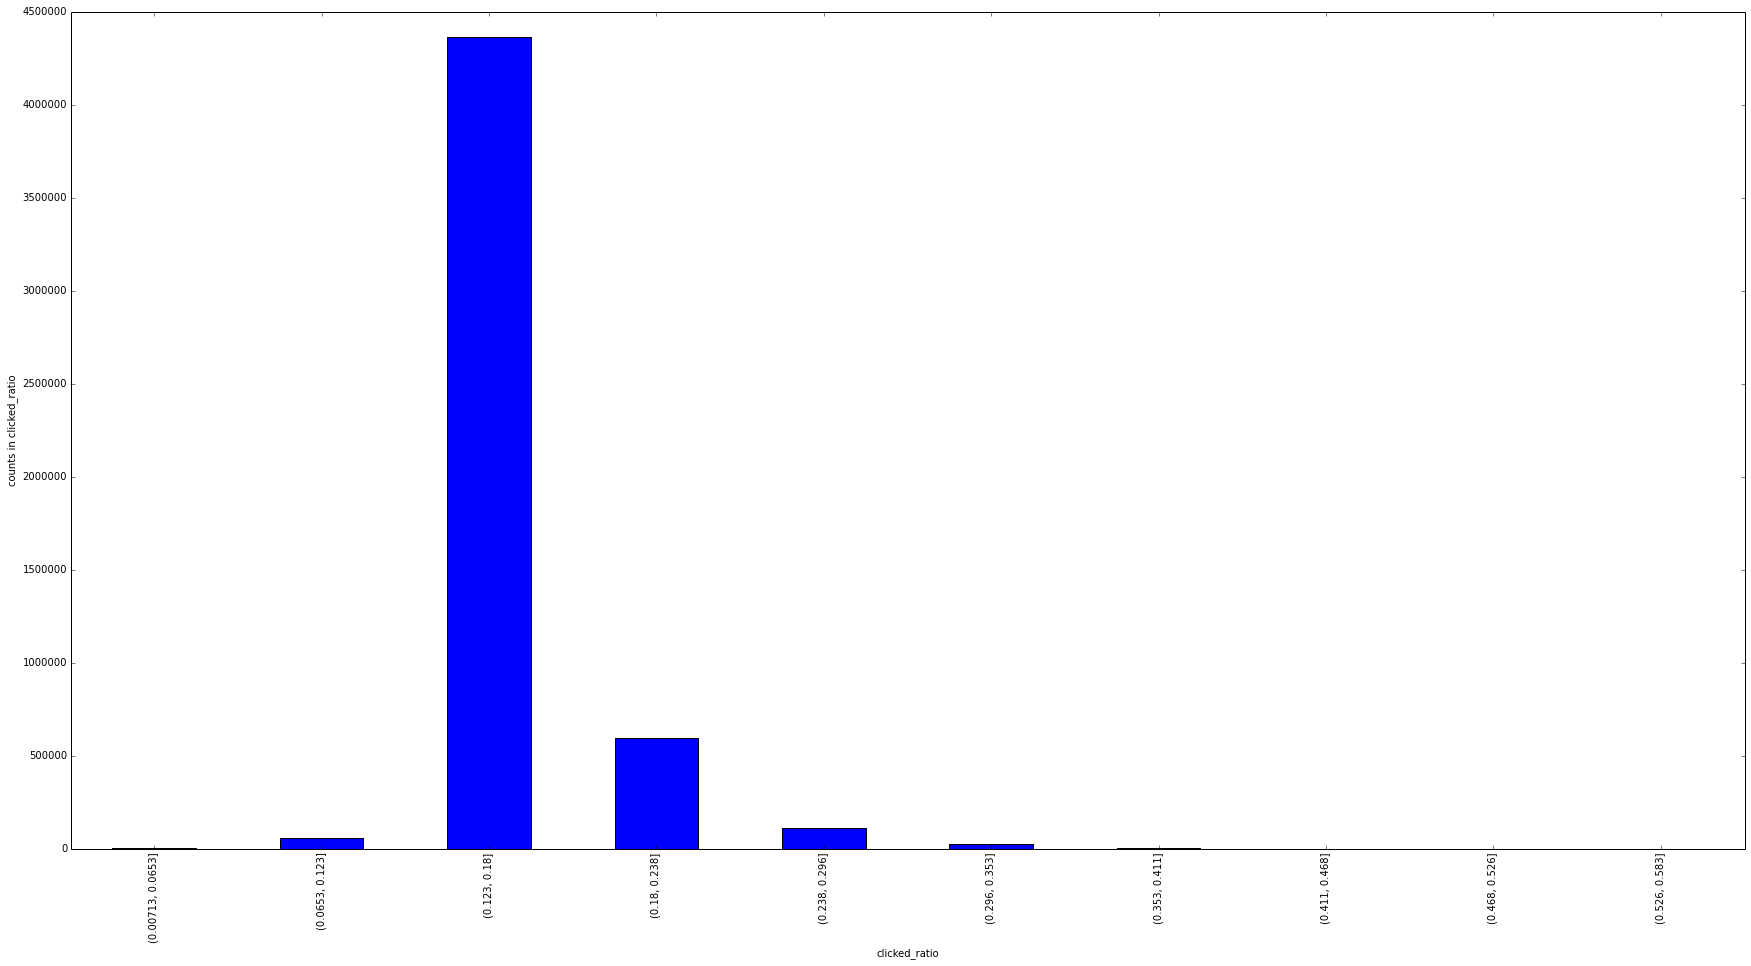

In [207]:
plot_data_cut(photo_data, 'clicked_ratio', 10)

In [208]:
def cover_length_discretization(num):
    if num == 0:
        return 0
    elif 0 < num <= 3:
        return 1
    elif 3 < num <= 10:
        return 2
    elif 10 < num <= 20:
        return 3
    else:
        return 4

In [209]:
photo_data.head()

,photo_id,exposure_num,duration_time,time,clicked_num,liked_num,followed_num,played_sum,duration_sum,clicked_ratio,liked_ratio,followed_ratio,played_ratio,cover_words,cover_length
0,6484142,13,11.0,7.610366e+11,5.0,0.0,0.0,34.0,143.0,0.268404,0.0,0.0,0.237762,"[229, 56]",2
1,4647664,2,11.0,7.610355e+11,1.0,0.0,0.0,12.0,22.0,0.210489,0.0,0.0,0.545455,"[17874, 14, 73, 29, 143, 1117, 14, 93]",8
2,4994626,34,10.0,7.610369e+11,9.0,0.0,0.0,72.0,340.0,0.235732,0.0,0.0,0.211765,"[87420, 30620, 15258]",3
3,4416881,1,9.0,7.611192e+11,0.0,0.0,0.0,0.0,9.0,0.164285,0.0,0.0,0.000000,[],0
4,2597756,2,11.0,7.611194e+11,0.0,0.0,0.0,0.0,22.0,0.155202,0.0,0.0,0.000000,[],0


In [210]:
photo_data[photo_data['cover_length']>30].shape

(5733, 15)

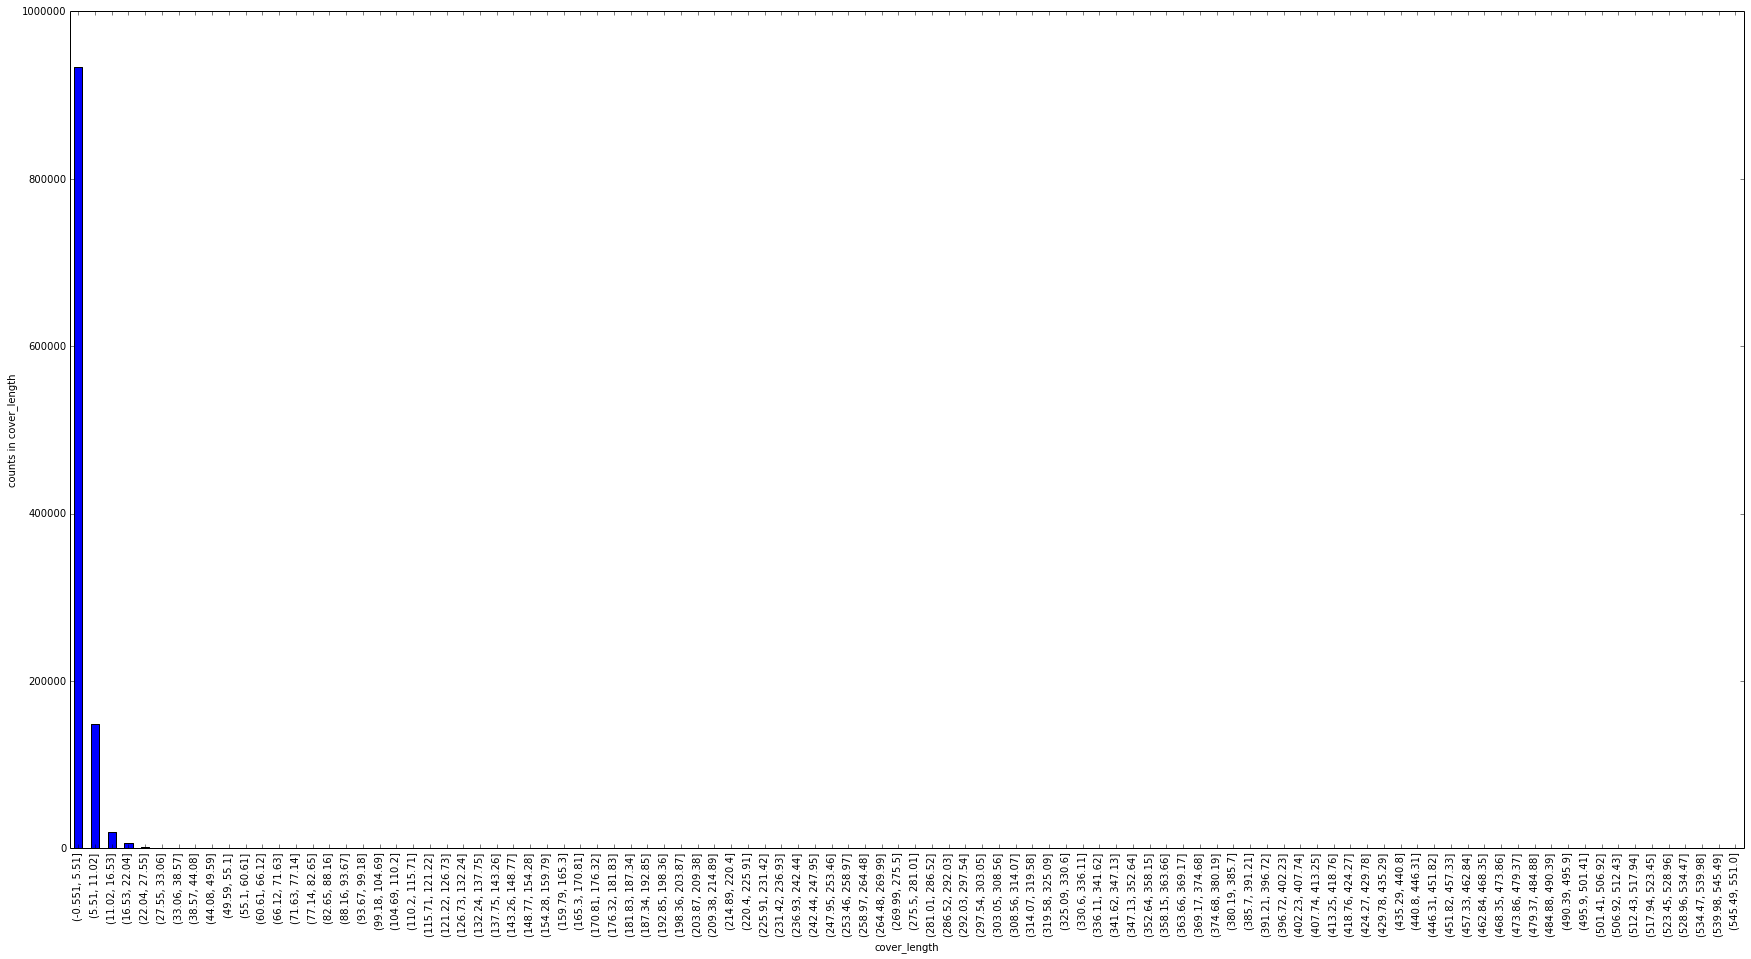

In [75]:
plot_data_cut(photo_data, 'cover_length', 100)

In [76]:
user_item_train = pd.merge(user_item_train, photo_data,
                              how='left',
                              on=['photo_id'])

In [77]:
# 用户点击视频中对人脸和颜值以及年龄的偏好，以后考虑离散化
favor_cols = ['cover_length']
favors = user_item_train.loc[user_item_train['click']==1, favor_cols+['user_id']]

# 文本平均长度作为偏爱率
favors['cover_length_favor'] = favors['cover_length'].groupby(favors['user_id']).transform('mean')

favors.drop_duplicates(['user_id'], inplace=True)
favors.drop(favor_cols, axis=1, inplace=True)
favors.reset_index(drop=True, inplace=True)


In [ ]:
def cover_length_favor_discretization(num):
    if num == 0:
        return 0
    elif 0 < num <= 3:
        return 1
    elif 3 < num <= 10:
        return 2
    else:
        return 3

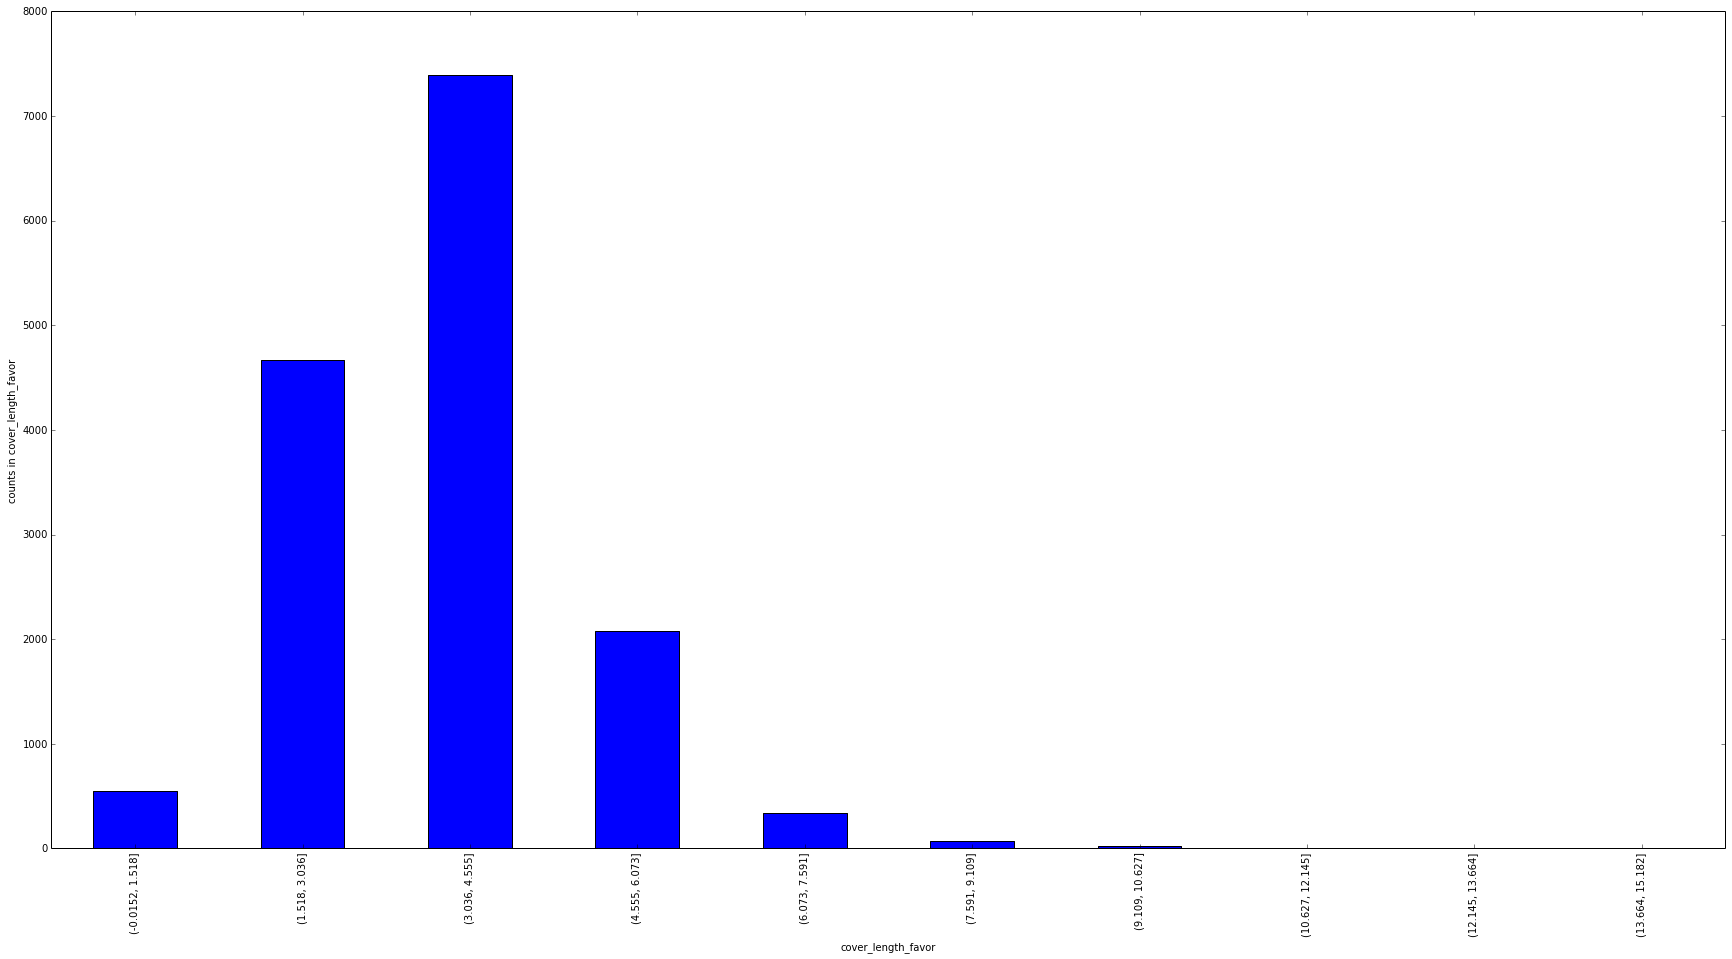

In [82]:
plot_data_cut(favors, 'cover_length_favor', 10)

In [89]:
bs = BayesianSmoothing(1, 1)
I, C = items['exposure_num'].values, items['clicked_num'].values
bs.update(I, C, 1000, 0.0000000001)
print(bs.alpha, bs.beta)
alpha, beta = bs.alpha, bs.beta
ctr = []
for i in range(len(I)):
    ctr.append((C[i]+alpha)/(I[i]+alpha+beta))
items['smooth_clicked_ratio'] = ctr

(2.8072236088257325, 13.280311727786964)


In [92]:
2.8/(2.8+13.2)

0.175